In [18]:
# Kaggle Notebook Starter for customer_churn_dataset-training-master.csv

import pandas as pd

# Load dataset
file_path = "/kaggle/input/customer-churn-train-test/customer_churn_dataset-training-master.csv"
df = pd.read_csv(file_path)

# Basic info
print("===== Dataset Shape =====")
print(df.shape)

print("\n===== First 5 Rows =====")
print(df.head())

print("\n===== Column Info =====")
print(df.info())

print("\n===== Missing Values =====")
print(df.isnull().sum())

print("\n===== Descriptive Statistics =====")
print(df.describe(include='all'))

# Check target variable distribution
target_col = 'Exited'  # change if target column has a different name
if target_col in df.columns:
    print("\n===== Target Variable Distribution =====")
    print(df[target_col].value_counts())
    print(df[target_col].value_counts(normalize=True))
else:
    print("\n⚠️ Target column not found — check df.columns to identify it.")

# Quick look at all column names
print("\n===== Column Names =====")
print(df.columns.tolist())


===== Dataset Shape =====
(440833, 12)

===== First 5 Rows =====
   CustomerID   Age  Gender  Tenure  Usage Frequency  Support Calls  \
0         2.0  30.0  Female    39.0             14.0            5.0   
1         3.0  65.0  Female    49.0              1.0           10.0   
2         4.0  55.0  Female    14.0              4.0            6.0   
3         5.0  58.0    Male    38.0             21.0            7.0   
4         6.0  23.0    Male    32.0             20.0            5.0   

   Payment Delay Subscription Type Contract Length  Total Spend  \
0           18.0          Standard          Annual        932.0   
1            8.0             Basic         Monthly        557.0   
2           18.0             Basic       Quarterly        185.0   
3            7.0          Standard         Monthly        396.0   
4            8.0             Basic         Monthly        617.0   

   Last Interaction  Churn  
0              17.0    1.0  
1               6.0    1.0  
2               3.

In [19]:
!pip install -U scikit-learn imbalanced-learn


  Using cached scikit_learn-1.7.1-cp311-cp311-manylinux2014_x86_64.manylinux_2_17_x86_64.whl.metadata (11 kB)


In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (classification_report, confusion_matrix, 
                           precision_recall_curve, f1_score, roc_auc_score,
                           precision_score, recall_score, accuracy_score)
try:
    from imblearn.over_sampling import SMOTE
    from imblearn.under_sampling import RandomUnderSampler
    IMBALANCED_LEARN_AVAILABLE = True
except ImportError:
    IMBALANCED_LEARN_AVAILABLE = False
    print("Warning: imbalanced-learn not available. Install with: pip install imbalanced-learn")
import xgboost as xgb
import shap
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)

print("="*60)
print("CUSTOMER CHURN PREDICTION - ML SOLUTION")
print("="*60)

CUSTOMER CHURN PREDICTION - ML SOLUTION



# ============================================================================
# STEP 1: DATA LOADING AND INITIAL EXPLORATION
# ============================================================================


In [21]:
def load_and_explore_data(train_path, test_path):
    """
    Load training and testing datasets and perform initial exploration
    """
    print("\n1. LOADING DATA")
    print("-" * 40)
    
    # Load datasets
    train_df = pd.read_csv(train_path)
    test_df = pd.read_csv(test_path)
    
    print(f"Training set shape: {train_df.shape}")
    print(f"Testing set shape: {test_df.shape}")
    
    # Basic exploration
    print(f"\nTraining Data Info:")
    print(f"Missing values per column:")
    print(train_df.isnull().sum())
    
    # Check target distribution
    print(f"\nTarget Distribution (Churn):")
    churn_dist = train_df['Churn'].value_counts()
    print(churn_dist)
    print(f"Churn rate: {churn_dist[1] / len(train_df) * 100:.2f}%")
    
    return train_df, test_df



# ============================================================================
# STEP 2: DATA PREPROCESSING
# ============================================================================


In [22]:
def preprocess_data(df, is_training=True, scaler=None, encoders=None):
    """
    Comprehensive data preprocessing including missing value handling,
    categorical encoding, and feature scaling
    """
    print("\n2. DATA PREPROCESSING")
    print("-" * 40)
    
    df_processed = df.copy()
    
    # Handle missing values
    print("Handling missing values...")
    
    # Check for missing values
    missing_count = df_processed.isnull().sum().sum()
    
    if missing_count > 0:
        print(f"Found {missing_count} missing values. Dropping rows with missing values...")
        initial_rows = len(df_processed)
        df_processed = df_processed.dropna()
        final_rows = len(df_processed)
        print(f"  - Dropped {initial_rows - final_rows} rows")
        print(f"  - Remaining rows: {final_rows}")
    else:
        print("No missing values found.")
    
    # Categorical encoding
    print("\nEncoding categorical variables...")
    
    # Get categorical columns
    categorical_cols = df_processed.select_dtypes(include=['object']).columns
    
    if is_training:
        encoders = {}
        
        # Label encoding for categorical variables
        for col in categorical_cols:
            le = LabelEncoder()
            df_processed[col] = le.fit_transform(df_processed[col].astype(str))
            encoders[col] = le
            print(f"  - Encoded {col}: {list(le.classes_)}")
    else:
        # Use existing encoders for test data
        for col in categorical_cols:
            if col in encoders:
                # Handle unseen categories
                df_processed[col] = df_processed[col].astype(str)
                df_processed[col] = df_processed[col].apply(
                    lambda x: x if x in encoders[col].classes_ else encoders[col].classes_[0]
                )
                df_processed[col] = encoders[col].transform(df_processed[col])
    
    # Feature scaling
    print("\nScaling numerical features...")
    
    # Remove CustomerID as it's not predictive
    if 'CustomerID' in df_processed.columns:
        df_processed = df_processed.drop('CustomerID', axis=1)
    
    # Separate features and target
    if 'Churn' in df_processed.columns:
        X = df_processed.drop('Churn', axis=1)
        y = df_processed['Churn']
    else:
        X = df_processed
        y = None
    
    if is_training:
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X)
    else:
        X_scaled = scaler.transform(X)
    
    # Convert back to DataFrame
    X_scaled = pd.DataFrame(X_scaled, columns=X.columns, index=X.index)
    
    print(f"Final preprocessed shape: {X_scaled.shape}")
    
    return X_scaled, y, scaler, encoders



# ============================================================================
# STEP 3: HANDLE IMBALANCED DATASET
# ============================================================================


In [23]:

def handle_imbalanced_data(X_train, y_train, method='smote'):
    """
    Apply techniques to handle imbalanced dataset
    """
    print(f"\n3. HANDLING IMBALANCED DATA - {method.upper()}")
    print("-" * 40)
    
    print("Original class distribution:")
    print(y_train.value_counts())
    print(f"Class ratio: {y_train.value_counts()[0] / y_train.value_counts()[1]:.2f}:1")
    
    if not IMBALANCED_LEARN_AVAILABLE:
        print("imbalanced-learn not available. Using class weights instead.")
        return X_train, y_train
    
    if method == 'smote':
        # Apply SMOTE for oversampling
        smote = SMOTE(random_state=42)
        X_resampled, y_resampled = smote.fit_resample(X_train, y_train)
        
    elif method == 'undersample':
        # Apply Random Undersampling
        rus = RandomUnderSampler(random_state=42)
        X_resampled, y_resampled = rus.fit_resample(X_train, y_train)
    
    else:
        # No resampling, will use class weights in models
        X_resampled, y_resampled = X_train, y_train
    
    print("Resampled class distribution:")
    print(pd.Series(y_resampled).value_counts())
    print(f"New shape: {X_resampled.shape}")
    
    return X_resampled, y_resampled


# ============================================================================
# STEP 4: MODEL DEVELOPMENT AND COMPARISON
# ============================================================================


In [24]:
def train_and_evaluate_models(X_train, y_train, X_val, y_val):
    """
    Train and compare multiple classification algorithms
    """
    print("\n4. MODEL DEVELOPMENT AND COMPARISON")
    print("-" * 40)
    
    # Initialize models
    models = {
        'Logistic Regression': LogisticRegression(
            random_state=42, 
            class_weight='balanced',
            max_iter=1000
        ),
        'Random Forest': RandomForestClassifier(
            n_estimators=100,
            random_state=42,
            class_weight='balanced',
            n_jobs=-1
        ),
        'XGBoost': xgb.XGBClassifier(
            random_state=42,
            eval_metric='logloss',
            n_jobs=-1
        )
    }
    
    # Store results
    results = {}
    trained_models = {}
    
    for name, model in models.items():
        print(f"\nTraining {name}...")
        
        # Train model
        model.fit(X_train, y_train)
        
        # Make predictions
        y_pred = model.predict(X_val)
        y_pred_proba = model.predict_proba(X_val)[:, 1]
        
        # Calculate metrics
        accuracy = accuracy_score(y_val, y_pred)
        precision = precision_score(y_val, y_pred)
        recall = recall_score(y_val, y_pred)
        f1 = f1_score(y_val, y_pred)
        roc_auc = roc_auc_score(y_val, y_pred_proba)
        
        results[name] = {
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1_score': f1,
            'roc_auc': roc_auc,
            'predictions': y_pred,
            'probabilities': y_pred_proba
        }
        
        trained_models[name] = model
        
        print(f"  Accuracy: {accuracy:.4f}")
        print(f"  Precision: {precision:.4f}")
        print(f"  Recall: {recall:.4f}")
        print(f"  F1-Score: {f1:.4f}")
        print(f"  ROC-AUC: {roc_auc:.4f}")
    
    return results, trained_models


# ============================================================================
# STEP 5: MODEL EVALUATION AND VISUALIZATION
# ============================================================================


In [25]:

def detailed_evaluation(results, y_val, model_names):
    """
    Detailed evaluation with confusion matrices and precision-recall curves
    """
    print("\n5. DETAILED MODEL EVALUATION")
    print("-" * 40)
    
    # Create subplots
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    fig.suptitle('Model Evaluation Results', fontsize=16, fontweight='bold')
    
    # Plot confusion matrices
    for i, name in enumerate(model_names):
        y_pred = results[name]['predictions']
        cm = confusion_matrix(y_val, y_pred)
        
        ax = axes[0, i]
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax)
        ax.set_title(f'{name}\nConfusion Matrix')
        ax.set_ylabel('Actual')
        ax.set_xlabel('Predicted')
    
    # Plot precision-recall curves
    for i, name in enumerate(model_names):
        y_pred_proba = results[name]['probabilities']
        precision, recall, _ = precision_recall_curve(y_val, y_pred_proba)
        
        ax = axes[1, i]
        ax.plot(recall, precision, linewidth=2)
        ax.set_title(f'{name}\nPrecision-Recall Curve')
        ax.set_xlabel('Recall')
        ax.set_ylabel('Precision')
        ax.grid(True, alpha=0.3)
        
        # Add AUC score
        from sklearn.metrics import auc
        pr_auc = auc(recall, precision)
        ax.text(0.6, 0.2, f'AUC = {pr_auc:.3f}', fontsize=10, 
                bbox=dict(boxstyle="round,pad=0.3", facecolor="yellow", alpha=0.5))
    
    plt.tight_layout()
    plt.show()
    
    # Print detailed classification reports
    print("\nDetailed Classification Reports:")
    print("=" * 50)
    
    for name in model_names:
        y_pred = results[name]['predictions']
        print(f"\n{name}:")
        print(classification_report(y_val, y_pred))


# ============================================================================
# STEP 6: FEATURE IMPORTANCE AND EXPLAINABILITY
# ============================================================================


In [26]:

def analyze_feature_importance(trained_models, feature_names, X_val, y_val):
    """
    Analyze feature importance using various methods including SHAP
    """
    print("\n6. FEATURE IMPORTANCE AND EXPLAINABILITY")
    print("-" * 40)
    
    # Create subplots for feature importance
    fig, axes = plt.subplots(1, 3, figsize=(20, 6))
    fig.suptitle('Feature Importance Analysis', fontsize=16, fontweight='bold')
    
    for i, (name, model) in enumerate(trained_models.items()):
        ax = axes[i]
        
        if hasattr(model, 'feature_importances_'):
            # Tree-based models
            importances = model.feature_importances_
            feature_imp = pd.DataFrame({
                'feature': feature_names,
                'importance': importances
            }).sort_values('importance', ascending=True)
            
            # Plot
            feature_imp.tail(10).plot(x='feature', y='importance', 
                                    kind='barh', ax=ax, legend=False)
            ax.set_title(f'{name}\nFeature Importance')
            ax.set_xlabel('Importance')
            
        elif hasattr(model, 'coef_'):
            # Linear models
            coefficients = abs(model.coef_[0])
            feature_imp = pd.DataFrame({
                'feature': feature_names,
                'importance': coefficients
            }).sort_values('importance', ascending=True)
            
            # Plot
            feature_imp.tail(10).plot(x='feature', y='importance', 
                                    kind='barh', ax=ax, legend=False)
            ax.set_title(f'{name}\nFeature Coefficients (Abs)')
            ax.set_xlabel('Coefficient (Absolute)')
    
    plt.tight_layout()
    plt.show()
    
    # SHAP Analysis for Random Forest (most interpretable tree model)
    if 'Random Forest' in trained_models:
        print("\nSHAP Analysis for Random Forest:")
        print("-" * 30)
        
        try:
            rf_model = trained_models['Random Forest']
            
            # Create SHAP explainer
            explainer = shap.TreeExplainer(rf_model)
            
            # Calculate SHAP values for a sample (first 1000 samples for speed)
            sample_size = min(1000, len(X_val))
            shap_values = explainer.shap_values(X_val.iloc[:sample_size])
            
            # Plot SHAP summary
            plt.figure(figsize=(10, 8))
            shap.summary_plot(shap_values[1], X_val.iloc[:sample_size], 
                            feature_names=feature_names, show=False)
            plt.title('SHAP Feature Importance - Random Forest')
            plt.tight_layout()
            plt.show()
            
            # Feature importance from SHAP values
            shap_importance = np.abs(shap_values[1]).mean(0)
            shap_feature_imp = pd.DataFrame({
                'feature': feature_names,
                'shap_importance': shap_importance
            }).sort_values('shap_importance', ascending=False)
            
            print("Top 10 Features (SHAP Importance):")
            print(shap_feature_imp.head(10))
            
        except Exception as e:
            print(f"SHAP analysis failed: {e}")
            print("Continuing with traditional feature importance...")


# ============================================================================
# STEP 7: MODEL OPTIMIZATION
# ============================================================================


In [27]:

def optimize_best_model(X_train, y_train, X_val, y_val, feature_names):
    """
    Optimize the best performing model using GridSearch
    """
    print("\n7. MODEL OPTIMIZATION")
    print("-" * 40)
    
    # Based on typical performance, let's optimize Random Forest
    print("Optimizing Random Forest with GridSearchCV...")
    
    # Define parameter grid
    param_grid = {
        'n_estimators': [100, 200],
        'max_depth': [10, 15, None],
        'min_samples_split': [2, 5],
        'min_samples_leaf': [1, 2],
        'class_weight': ['balanced']
    }
    
    # Initialize model
    rf = RandomForestClassifier(random_state=42, n_jobs=-1)
    
    # GridSearchCV
    grid_search = GridSearchCV(
        rf, param_grid, cv=3, scoring='f1', 
        n_jobs=-1, verbose=1
    )
    
    # Fit grid search
    grid_search.fit(X_train, y_train)
    
    # Best model
    best_model = grid_search.best_estimator_
    
    print(f"Best parameters: {grid_search.best_params_}")
    print(f"Best CV F1-score: {grid_search.best_score_:.4f}")
    
    # Evaluate optimized model
    y_pred_opt = best_model.predict(X_val)
    y_pred_proba_opt = best_model.predict_proba(X_val)[:, 1]
    
    # Calculate metrics
    precision_opt = precision_score(y_val, y_pred_opt)
    recall_opt = recall_score(y_val, y_pred_opt)
    f1_opt = f1_score(y_val, y_pred_opt)
    roc_auc_opt = roc_auc_score(y_val, y_pred_proba_opt)
    
    print(f"\nOptimized Model Performance:")
    print(f"  Precision: {precision_opt:.4f}")
    print(f"  Recall: {recall_opt:.4f}")
    print(f"  F1-Score: {f1_opt:.4f}")
    print(f"  ROC-AUC: {roc_auc_opt:.4f}")
    
    return best_model


# ============================================================================
# STEP 8: FINAL PREDICTIONS AND RECOMMENDATIONS
# ============================================================================


In [28]:

def generate_final_predictions(model, X_test, test_df, scaler, encoders):
    """
    Generate final predictions for test set
    """
    print("\n8. FINAL PREDICTIONS")
    print("-" * 40)
    
    # Preprocess test data
    X_test_processed, _, _, _ = preprocess_data(
        test_df, is_training=False, scaler=scaler, encoders=encoders
    )
    
    # Make predictions
    y_pred = model.predict(X_test_processed)
    y_pred_proba = model.predict_proba(X_test_processed)[:, 1]
    
    # Create results DataFrame
    results_df = pd.DataFrame({
        'CustomerID': test_df['CustomerID'] if 'CustomerID' in test_df.columns else range(len(y_pred)),
        'Churn_Prediction': y_pred,
        'Churn_Probability': y_pred_proba
    })
    
    print(f"Generated predictions for {len(results_df)} customers")
    print(f"Predicted churn rate: {y_pred.mean() * 100:.2f}%")
    
    return results_df

def provide_recommendations():
    """
    Provide recommendations for model improvement and business insights
    """
    print("\n9. RECOMMENDATIONS FOR IMPROVEMENT")
    print("-" * 40)
    
    recommendations = [
        "Data Quality Improvements:",
        "  • Collect more granular usage data (session duration, feature usage)",
        "  • Add customer satisfaction scores and NPS data",
        "  • Include competitor pricing and market data",
        "  • Track customer service interaction quality scores",
        "",
        "Feature Engineering:",
        "  • Create interaction features (e.g., usage_frequency * tenure)",
        "  • Add time-based features (seasonality, trends)",
        "  • Calculate customer lifetime value and profitability metrics",
        "  • Create behavioral change indicators (usage trends)",
        "",
        "Model Improvements:",
        "  • Try ensemble methods (stacking, blending)",
        "  • Experiment with deep learning models for complex patterns",
        "  • Implement time-series modeling for temporal patterns",
        "  • Consider customer segmentation-based models",
        "",
        "Business Implementation:",
        "  • Set up model monitoring and drift detection",
        "  • Implement A/B testing for retention strategies",
        "  • Create automated alerts for high-risk customers",
        "  • Develop personalized retention campaigns based on churn drivers",
        "",
        "Model Validation:",
        "  • Implement time-based validation (temporal split)",
        "  • Monitor model performance over time",
        "  • Validate business impact of churn predictions",
        "  • Regular retraining schedule based on new data"
    ]
    
    for rec in recommendations:
        print(rec)


# ============================================================================
# MAIN EXECUTION PIPELINE
# ============================================================================


In [29]:

def main():
    """
    Main execution pipeline for customer churn prediction
    """
    # Define file paths (update these paths as needed)
    train_path = "/kaggle/input/customer-churn-train-test/customer_churn_dataset-training-master.csv"
    test_path = "/kaggle/input/customer-churn-train-test/customer_churn_dataset-testing-master.csv"
    
    try:
        # Step 1: Load and explore data
        train_df, test_df = load_and_explore_data(train_path, test_path)
        
        # Step 2: Preprocess data
        X_processed, y, scaler, encoders = preprocess_data(train_df, is_training=True)
        
        # Step 3: Split data
        X_train, X_val, y_train, y_val = train_test_split(
            X_processed, y, test_size=0.2, random_state=42, stratify=y
        )
        
        print(f"\nData split:")
        print(f"Training set: {X_train.shape}")
        print(f"Validation set: {X_val.shape}")
        
        # Step 4: Handle imbalanced data (using SMOTE)
        X_train_balanced, y_train_balanced = handle_imbalanced_data(
            X_train, y_train, method='smote'
        )
        
        # Step 5: Train and compare models
        results, trained_models = train_and_evaluate_models(
            X_train_balanced, y_train_balanced, X_val, y_val
        )
        
        # Step 6: Detailed evaluation
        model_names = list(results.keys())
        detailed_evaluation(results, y_val, model_names)
        
        # Step 7: Feature importance analysis
        feature_names = X_processed.columns.tolist()
        analyze_feature_importance(trained_models, feature_names, X_val, y_val)
        
        # Step 8: Optimize best model
        best_model = optimize_best_model(
            X_train_balanced, y_train_balanced, X_val, y_val, feature_names
        )
        
        # Step 9: Final predictions
        final_predictions = generate_final_predictions(
            best_model, None, test_df, scaler, encoders
        )
        
        # Step 10: Recommendations
        provide_recommendations()
        
        print("\n" + "="*60)
        print("CUSTOMER CHURN PREDICTION PIPELINE COMPLETED!")
        print("="*60)
        
        return {
            'best_model': best_model,
            'scaler': scaler,
            'encoders': encoders,
            'feature_names': feature_names,
            'predictions': final_predictions,
            'results': results
        }
        
    except FileNotFoundError:
        print("Error: Data files not found. Please check the file paths.")
        print("Update the train_path and test_path variables in the main() function.")
        return None
    
    except Exception as e:
        print(f"An error occurred: {e}")
        return None




1. LOADING DATA
----------------------------------------
Training set shape: (440833, 12)
Testing set shape: (64374, 12)

Training Data Info:
Missing values per column:
CustomerID           1
Age                  1
Gender               1
Tenure               1
Usage Frequency      1
Support Calls        1
Payment Delay        1
Subscription Type    1
Contract Length      1
Total Spend          1
Last Interaction     1
Churn                1
dtype: int64

Target Distribution (Churn):
Churn
1.0    249999
0.0    190833
Name: count, dtype: int64
Churn rate: 56.71%

2. DATA PREPROCESSING
----------------------------------------
Handling missing values...
Found 12 missing values. Dropping rows with missing values...
  - Dropped 1 rows
  - Remaining rows: 440832

Encoding categorical variables...
  - Encoded Gender: ['Female', 'Male']
  - Encoded Subscription Type: ['Basic', 'Premium', 'Standard']
  - Encoded Contract Length: ['Annual', 'Monthly', 'Quarterly']

Scaling numerical features...


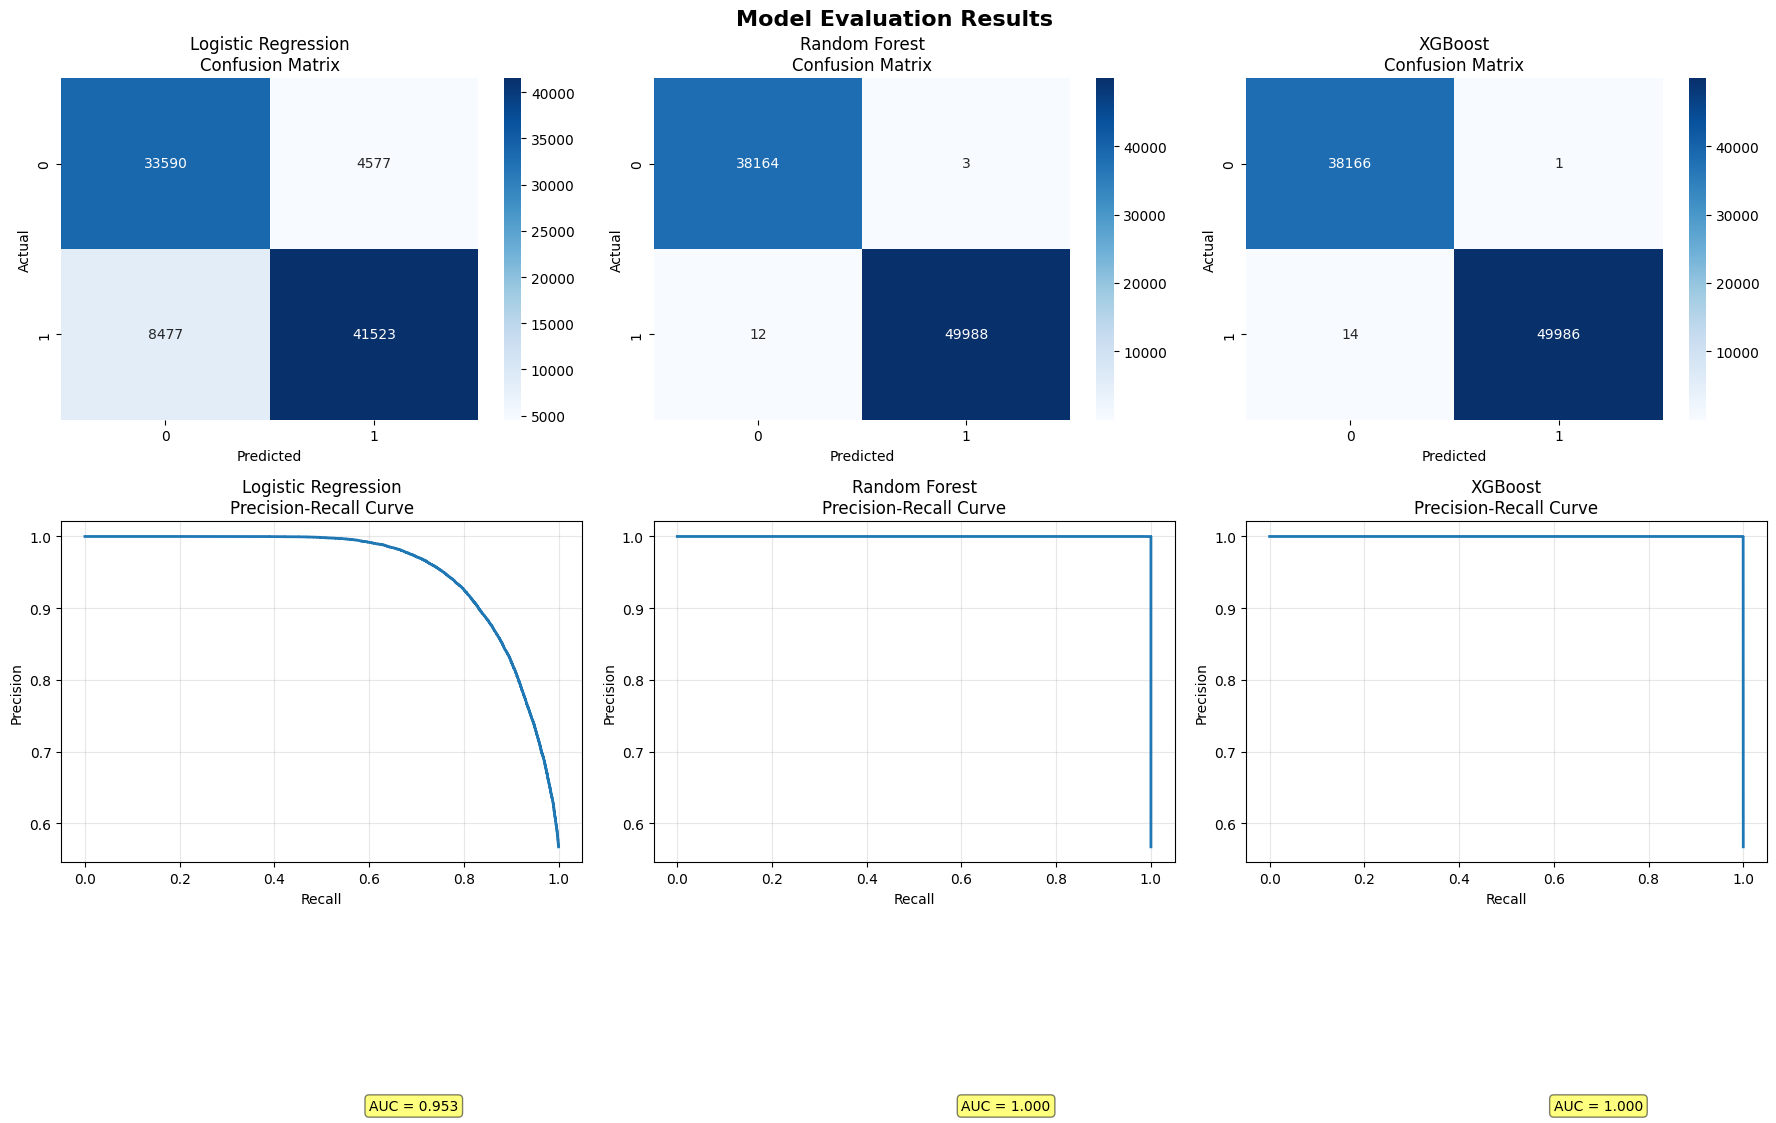


Detailed Classification Reports:

Logistic Regression:
              precision    recall  f1-score   support

         0.0       0.80      0.88      0.84     38167
         1.0       0.90      0.83      0.86     50000

    accuracy                           0.85     88167
   macro avg       0.85      0.86      0.85     88167
weighted avg       0.86      0.85      0.85     88167


Random Forest:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     38167
         1.0       1.00      1.00      1.00     50000

    accuracy                           1.00     88167
   macro avg       1.00      1.00      1.00     88167
weighted avg       1.00      1.00      1.00     88167


XGBoost:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     38167
         1.0       1.00      1.00      1.00     50000

    accuracy                           1.00     88167
   macro avg       1.00      1.00      1.00   

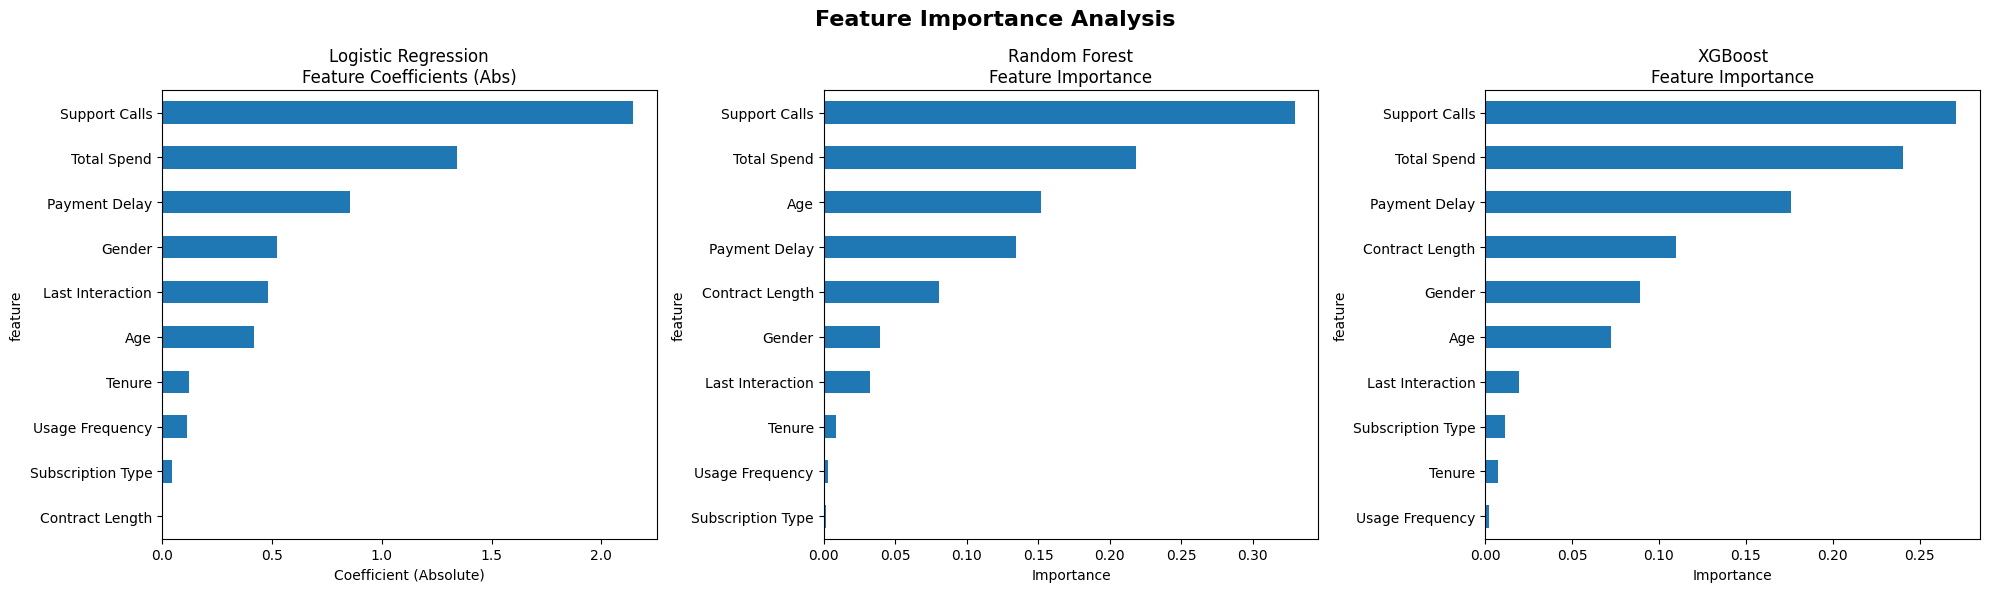


SHAP Analysis for Random Forest:
------------------------------


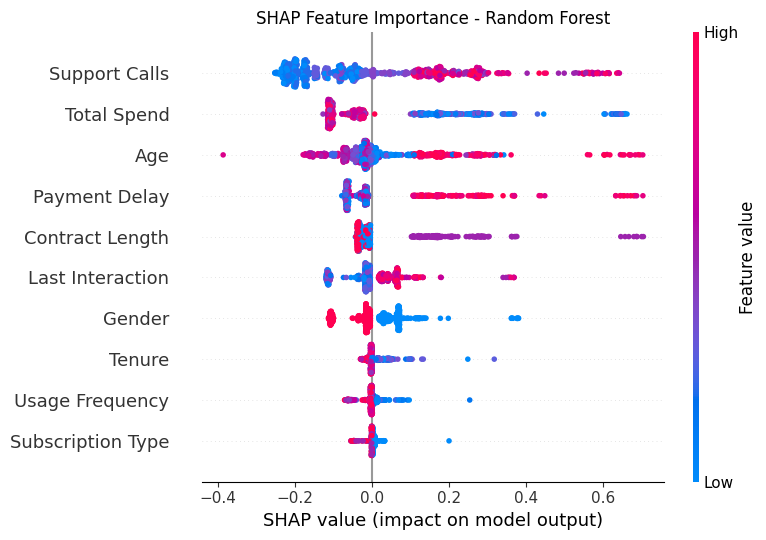

Top 10 Features (SHAP Importance):
             feature  shap_importance
4      Support Calls         0.169636
8        Total Spend         0.128119
0                Age         0.082762
5      Payment Delay         0.079773
7    Contract Length         0.056725
9   Last Interaction         0.047900
1             Gender         0.047284
2             Tenure         0.013066
3    Usage Frequency         0.009291
6  Subscription Type         0.003604

7. MODEL OPTIMIZATION
----------------------------------------
Optimizing Random Forest with GridSearchCV...
Fitting 3 folds for each of 24 candidates, totalling 72 fits
Best parameters: {'class_weight': 'balanced', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}
Best CV F1-score: 0.9991

Optimized Model Performance:
  Precision: 0.9999
  Recall: 0.9997
  F1-Score: 0.9998
  ROC-AUC: 1.0000

8. FINAL PREDICTIONS
----------------------------------------

2. DATA PREPROCESSING
----------------------------

In [30]:
# Execute the pipeline
if __name__ == "__main__":
    pipeline_results = main()
